In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
#from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,10**2)))
        X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [4]:
##  --- Within-host parameters


data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_unVacc = Data_df[(Data_df.cat_VaccStatus!='Boosted')*(Data_df.cat_VaccStatus!='Second dose')*(Data_df.cat_VaccStatus!='First dose') ]
Data_unVacc_symp = Data_unVacc[Data_unVacc.cat_SympEver != 'No']
IDs_Symp = Data_unVacc_symp.ID.unique()

IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

## --------------------- PK parameters -----------------------------
Indparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRestimatedIndividualParameters.txt'
Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'
Indparameters_PK = pd.read_csv(Indparameters_U_file)
Popparameters_PK = pd.read_csv(Popparameters_U_file)


index  = Popparameters_PK[Popparameters_PK.parameter == 'kPL_pop'].index[0]



In [5]:
Popparameters_PK

,parameter,value,se_sa,rse_sa
0,ka_pop,9.981385,1.961866,19.655244
1,kLP_pop,1.221685,0.256791,21.019428
2,kCl_pop,4.966978,0.443651,8.932005
3,kPL_pop,1.584821,0.274209,17.302203
4,Vol_pop,41743.310914,4390.894202,10.518797
5,omega_ka,0.374279,0.135138,36.106068
6,omega_kLP,0.098952,0.113261,114.461277
7,omega_kCl,0.032404,0.041542,128.199217
8,omega_kPL,0.102330,0.167674,163.856463
9,omega_Vol,0.122690,0.056759,46.261741


In [6]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [7]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [8]:
def PKPDParams(Popparameters, GetPopParams, GetParamsOmega, Emax, IC50, Hill, dose, PDOm):
    
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetPopParams(Popparameters, dose)
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    
    PKOm = GetParamsOmega(Popparameters, dose)
    PKOm_Val = PKOm['ka'], PKOm['kPL'], PKOm['kLP'], PKOm['kCl'],PKOm['Vol']
    PKPDOm = np.hstack((PKOm_Val, PDOm))
    eta = np.random.normal(np.zeros(len(PKPDOm)), PKPDOm, len(PKPDOm))
    PKPDInd = PKPDparams*np.exp(eta)
    if PKPDInd[5]>1:
        PKPDInd[5]=1
    return dict(zip(param_Order, PKPDInd))

In [9]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [10]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [11]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [12]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**2))
            v[v==2]=1
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == 1) & (t>Tmax))]

            while (PS_Duration != [] and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**2))
                v[v==2]=1
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == 1) & (t>Tmax))]
    
    return params, param_dict

In [24]:
n=0
Num= 400
KPLRange = np.linspace(1,3,11, endpoint=True)
KLPRange = np.linspace(1,3,11, endpoint=True)
KCLRange = np.linspace(2.5,5.5,11, endpoint=True)
PL_CL = []
for KPL in KPLRange:
    print(KPL)
    index  = Popparameters_PK[Popparameters_PK.parameter == 'kPL_pop'].index[0]
    Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kPL_pop'].value[index],KPL)
    for KCL in KCLRange:
        print("  "+ str(KCL))
        index  = Popparameters_PK[Popparameters_PK.parameter == 'kCl_pop'].index[0]
        Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kCl_pop'].value[index],KCL)

        dose = 300
        PotRed = np.ones(Num)

        r2 = []
        Cohort = Cohort_Prep(IDs_Symp, Num)
        TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
        VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                    parameters_df, Popparameters_df, fixed_params, 
                                                    param_order, param_dist, PKPDParams, 
                                                    Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                    IC50, Hill,PDOm, dose)
        VLInd, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
        
        for PotRed in range(1,150, 4):
            print("       "+str(PotRed))
            V = []
            drop_VL = []
            Mean_drop_VL_TotPop = []
            for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
                t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed, MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
                T,R,E,I,V, Ag, A1, A2 = y.T
                X = np.log10(np.maximum(V,10**2))
                X[X==2]=1
                tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
                tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
                drop_VL.append(X[tstart:tend]-X[tstart])

            Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
            t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
            t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
            t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
            t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
            r2.append(r2_score([0,-1.85, -3.25, -4.25, -5.15], 
                  [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], 
                   Mean_drop_VL_TotPop[t10],Mean_drop_VL_TotPop[t14]]))

        prf_index= np.argwhere(r2==max(r2))
        prf = range(1,150,4)[prf_index[0][0]]
            
        PL_CL.append({'KPL':KPL, 'KCL': KCL, 'prf': prf})


PL_CL = pd.DataFrame(PL_CL)

1.0
  2.5
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  2.8
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  3.1
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
 

       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  5.5
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
1.4
  2.5
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  2.8
       1
       5
       9
       13
       1

       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  5.199999999999999
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  5.5
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113


       133
       137
       141
       145
       149
  4.6
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  4.9
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  5.199999999999999
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
      

       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  4.3
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  4.6
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       

       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  4.0
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85
       89
       93
       97
       101
       105
       109
       113
       117
       121
       125
       129
       133
       137
       141
       145
       149
  4.3
       1
       5
       9
       13
       17
       21
       25
       29
       33
       37
       41
       45
       49
       53
       57
       61
       65
       69
       73
       77
       81
       85


In [13]:
n=0
Num= 400
Popparameters_PK = pd.read_csv(Popparameters_U_file)
KPLRange = np.linspace(1,3,11, endpoint=True)
KLPRange = np.linspace(1,3,11, endpoint=True)
KCLRange = np.linspace(2.5,5.5,11, endpoint=True)
LP_CL = []
for KLP in KLPRange:
    print(KLP)
    index  = Popparameters_PK[Popparameters_PK.parameter == 'kLP_pop'].index[0]
    Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kLP_pop'].value[index],KLP)
    for KCL in KCLRange:
        print("  "+ str(KCL))
        index  = Popparameters_PK[Popparameters_PK.parameter == 'kCl_pop'].index[0]
        Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kCl_pop'].value[index],KCL)

        dose = 300
        PotRed = np.ones(Num)

        r2 = []
        Cohort = Cohort_Prep(IDs_Symp, Num)
        TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
        VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                    parameters_df, Popparameters_df, fixed_params, 
                                                    param_order, param_dist, PKPDParams, 
                                                    Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                    IC50, Hill,PDOm, dose)
        VLInd, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
        for PotRed in range(1,150, 4):
            V = []
            drop_VL = []
            Mean_drop_VL_TotPop = []
            for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
                t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed, MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
                T,R,E,I,V, Ag, A1, A2 = y.T
                X = np.log10(np.maximum(V,10**2))
                X[X==2]=1
                tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
                tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
                drop_VL.append(X[tstart:tend]-X[tstart])

            Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
            t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
            t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
            t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
            t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
            r2.append(r2_score([0,-1.85, -3.25, -4.25, -5.15], 
                  [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], 
                   Mean_drop_VL_TotPop[t10],Mean_drop_VL_TotPop[t14]]))

        prf_index= np.argwhere(r2==max(r2))
        prf = range(1,150,4)[prf_index[0][0]]
            
        LP_CL.append({'KLP':KLP, 'KCL': KCL, 'prf': prf})


LP_CL = pd.DataFrame(LP_CL)

1.0
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
1.2
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
1.4
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
1.6
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
1.8
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
2.0
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
2.2
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
2.4000000000000004
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
2.6
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0
  4.3
  4.6
  4.9
  5.199999999999999
  5.5
2.8
  2.5
  2.8
  3.1
  3.4
  3.7
  4.0


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [35]:
LP_CL = pd.DataFrame(LP_CL)
pickle.dump(LP_CL , open('FigureData/PKSensAnal_LP_CL.pickle', 'wb'))
#pickle.dump(PL_CL , open('FigureData/PKSensAnal_PL_CL.pickle', 'wb'))

In [ ]:
n=0
Num= 400
Popparameters_PK = pd.read_csv(Popparameters_U_file)
KPLRange = np.linspace(1,3,11, endpoint=True)
KLPRange = np.linspace(1,3,11, endpoint=True)
KCLRange = np.linspace(2.5,5.5,11, endpoint=True)
LP_PL = []
for KLP in KLPRange:
    print(KLP)
    index  = Popparameters_PK[Popparameters_PK.parameter == 'kLP_pop'].index[0]
    Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kLP_pop'].value[index],KLP)
    for KPL in KPLRange:
        print("  "+ str(KPL))
        index  = Popparameters_PK[Popparameters_PK.parameter == 'kPL_pop'].index[0]
        Popparameters_PK['value'] = Popparameters_PK['value'].replace(Popparameters_PK[Popparameters_PK.parameter 
                                                                                   == 'kPL_pop'].value[index],KPL)

        dose = 300
        PotRed = np.ones(Num)

        r2 = []
        Cohort = Cohort_Prep(IDs_Symp, Num)
        TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
        VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                    parameters_df, Popparameters_df, fixed_params, 
                                                    param_order, param_dist, PKPDParams, 
                                                    Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                    IC50, Hill,PDOm, dose)
        VLInd, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
        for PotRed in range(1,150, 4):
            V = []
            drop_VL = []
            Mean_drop_VL_TotPop = []
            for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
                t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed, MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
                T,R,E,I,V, Ag, A1, A2 = y.T
                X = np.log10(np.maximum(V,10**2))
                X[X==2]=1
                tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
                tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
                drop_VL.append(X[tstart:tend]-X[tstart])

            Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
            t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
            t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
            t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
            t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
            r2.append(r2_score([0,-1.85, -3.25, -4.25, -5.15], 
                  [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], 
                   Mean_drop_VL_TotPop[t10],Mean_drop_VL_TotPop[t14]]))

        prf_index= np.argwhere(r2==max(r2))
        prf = range(1,150,4)[prf_index[0][0]]
            
        LP_PL.append({'KLP':KLP, 'KPL': KPL, 'prf': prf})


LP_PL = pd.DataFrame(LP_PL)

In [32]:
LP_PL= pickle.load(open('FigureData/PKSensAnal_LP_PL.pickle', 'rb'))
PL_CL  = pickle.load(open('FigureData/PKSensAnal_PL_CL.pickle', 'rb'))

In [36]:
LP_CL

,KLP,KCL,prf
0,1.0,2.5,133
1,1.0,2.8,133
2,1.0,3.1,97
3,1.0,3.4,89
4,1.0,3.7,85
...,...,...,...
99,2.8,2.5,149
100,2.8,2.8,145
101,2.8,3.1,125
102,2.8,3.4,101


In [85]:
LP_CL['KLP'] = LP_CL['KLP'].round(2)
LP_CL['KCL'] =LP_CL['KCL'].round(2)
lp_cl  = LP_CL.pivot(index='KLP', columns='KCL', values='prf')


PL_CL['KPL'] = PL_CL['KPL'].round(2)
PL_CL['KCL'] =PL_CL['KCL'].round(2)
pl_cl  = PL_CL.pivot(index='KPL', columns='KCL', values='prf')


LP_PL['KLP'] = LP_PL['KLP'].round(2)
LP_PL['KPL'] =LP_PL['KPL'].round(2)
lp_pl  = LP_PL.pivot(index='KLP', columns='KPL', values='prf')


Text(0.5, 16.5, '')

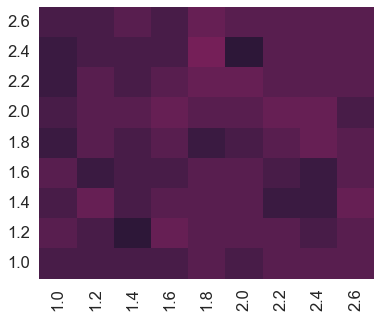

In [87]:
%matplotlib inline
fig = plt.figure(figsize = (6,5))
sns.set(font_scale=1.5)
ax = sns.heatmap(lp_pl, vmin= 40, vmax = 150, cbar = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.ylim([0, 9])
plt.xlim([0, 9])
plt.ylabel('')
plt.xlabel('')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (6,5))
sns.set(font_scale=1.5)
ax = sns.heatmap(pl_cl, vmin= 40, vmax = 150, cbar = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.ylim([0, 9])
plt.xlim([0, 9])
plt.ylabel('')
plt.xlabel('')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (6,5))
sns.set(font_scale=1.5)
ax = sns.heatmap(lp_cl, vmin= 40, vmax = 150, cbar = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.ylim([0, 9])
plt.xlim([0, 9])
plt.ylabel('')
plt.xlabel('')